# 短文主題模型GSDMM與BTM比較

> 原題目為使用[shorttext](https://pypi.org/project/shorttext/)套件，跟著教學照做之後，發現實作上遇到蠻多問題，轉而參考[Short Text Topic Modeling](https://towardsdatascience.com/short-text-topic-modeling-70e50a57c883)使用[GSDMM](https://github.com/rwalk/gsdmm)(Gibbs Sampling Dirichlet Mixture Model)。

### Background
在短文主題模型（STTM，Short Text Topic Modeling) 的分析中，GSDMM與BTM同樣是window-based的取向，同樣採用Gibbs Sampling算法，不過參數設定過程有所差異。


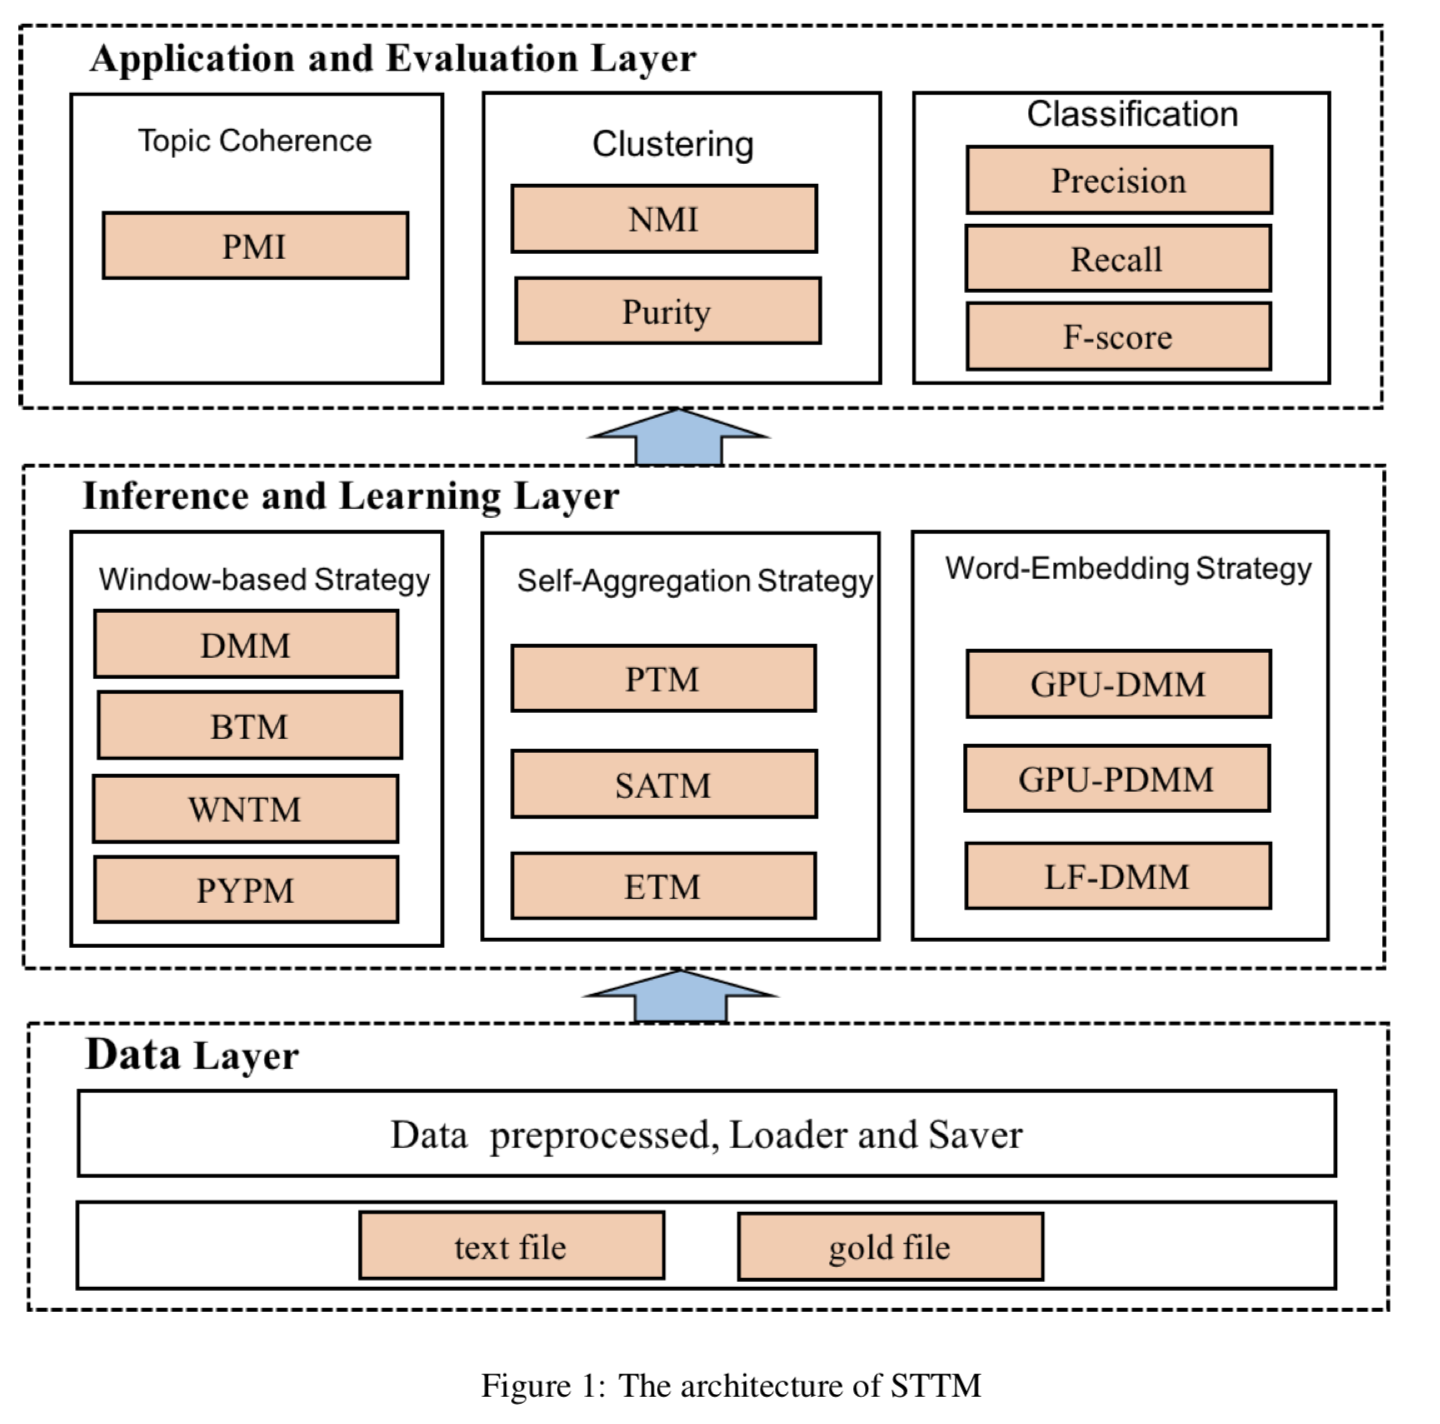Figure 1. (Qiang, Li, Yuan, Liu, & Wu ,2018)


以下以實作初步探索兩者的差異。

#### 1) GSDMM
在實作中，在Python利用GSDMM的相關套件進行文本分析，能進行事先的文字處理，整體的靈活度較高。

進行GSDMM計算前，文字處理的過程與其他文本分析無太多差異，利用nltk套件可以滿足所需去除停用詞、標點符號等不必要的資訊。在這次的訓練中，我先去除了所有的超連結網址，以及抓下來的文本中「&」造成的「amp」贅詞。可以在下方的結果中，看到較乾淨的分詞結果。

接著就進行模型的訓練，這部分皆利用GSDMM的相關套件完成。最後在結果上，我認為主題萃取的結果符合預期，各個主題有所差異，能看出所指涉的事件，關鍵字中也無其他贅詞。

#### 2) BTM
Python上，在我能力所及內，BTM的套件並無太多彈性。只要進行事先的文字預處理，Biterm就無法依據素材進行分析。這部分也許與原始碼的編寫有關係，但因為時間及能力無法觸及原始碼的改動，所以就先以原始的Twitter資料進行分析處理。

因為文本的處理程度不佳，因此在結果呈現上，也未如第一部分完整。透過pyLDAvis，可以看出主題的分野，以及關鍵字的分佈。可惜的是，若文本能夠處理乾淨，在解讀上會更有意思。([pyLDAvis結果](https://tynnie.github.io/python_tm_class_note/btm/vis/online_btm_0520.html))

此外，BTM的套件在訓練模型時，所需的成本較多，不僅時間長、花費的效能也多。我認為這與BTM的計算方式有關，在進行較小單位的處理時，所需的處理資源也較多。

###### 1000則Tweets約半小時、每個chunk要3-4分鐘；3500則Tweets約3.5小時、每個chunk要5-7分鐘；10000則Tweets約8.5小時（好像快10小時）、每個chunk要31-32分鐘。

### Reference
Qiang, J., Li, Y., Yuan, Y., Liu, W., & Wu, X. (2018). STTM: A tool for short text topic modeling. arXiv preprint arXiv:1808.02215.

### Note
- GSDMM可以參考[A Dirichlet Multinomial Mixture Model-based Approach for Short Text Clustering](http://dbgroup.cs.tsinghua.edu.cn/wangjy/papers/KDD14-GSDMM.pdf)
- BTM可以參考[A Biterm Topic Model for Short Texts](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.402.4032&rep=rep1&type=pdf)


## Topic modeling : GSDMM
### Data Preparation
[code-Short Text Topic Modeling](https://towardsdatascience.com/short-text-topic-modeling-70e50a57c883)

In [1]:
import pandas as pd
df = pd.read_csv("ref/twitter/taiwan_tweets_text.csv")
df = df[:3500]
df.info()
df.text.to_list()[:2]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3500 non-null   int64 
 1   text        3500 non-null   object
dtypes: int64(1), object(1)
memory usage: 54.8+ KB


['Creativity, free thought &amp; innovation are what it takes to combat #Coronavirus. The #US-#Taiwan Epidemic Prevention Hackathon shows how like-minded partners can harness the power of freedom &amp; democracy for the greater good. Thanks for recognizing #TaiwanCanHelp, @statedeptspox. https://t.co/EhWVGtKSiK',
 '“Taiwan should be a member of the World Health Organization.”\n\nWith a little more than 2 weeks before the @WHO holds its next key meeting, countries around the world are voicing their support for #Taiwan to be included. https://t.co/BErG8kmUxZ']

In [2]:
import re
import string
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stopword_list = stopwords.words('english')
  
def remove_unrelated_marks(tokens):
    tokens = re.sub(r'&amp;|http[s]:[/A-Za-z\.0-9]*|nan|#|@', '', tokens)
    tokens = word_tokenize(tokens) 
#     print(tokens)
    c_t = [tok for tok in tokens if tok not in string.punctuation]
    clean_tokens = [tok for tok in c_t if tok.isalpha()]
    return ' '.join([tok for tok in clean_tokens if tok.lower() not in stopword_list])

df.text = df.text.apply(remove_unrelated_marks)
# df.text = df.text.apply(lambda x: remove_unrelated_marks(x))
print(df.text.tolist()[:1])

['Creativity free thought innovation takes combat Coronavirus Epidemic Prevention Hackathon shows partners harness power freedom democracy greater good Thanks recognizing TaiwanCanHelp statedeptspox']


### Model Training

In [3]:
from nltk.tokenize import word_tokenize
comments = df.text.apply(lambda x: word_tokenize(x))

vocab = [item for items in comments for item in items]
n_terms = len(vocab)
print(comments[:2])
print(vocab[:2])
print("Voc size:", n_terms)
print("Number of documents:", len(comments))

0    [Creativity, free, thought, innovation, takes,...
1    [Taiwan, member, World, Health, little, weeks,...
Name: text, dtype: object
['Creativity', 'free']
Voc size: 57853
Number of documents: 3500


In [4]:
# Useful libs
from sklearn.datasets import fetch_20newsgroups
import pickle
import numpy as np
# STTM lib from Github
from gsdmm import MovieGroupProcess

# Train a new model 

# Init of the Gibbs Sampling Dirichlet Mixture Model algorithm
mgp = MovieGroupProcess(K=20, alpha=0.1, beta=0.1, n_iters=5)

#vocab = set(x for tweet in tweets for x in tweet)
n_terms = len(vocab)
n_tweets = len(comments)

# Fit the model on the data given the chosen seeds
y = mgp.fit(comments, n_terms)

# Save model
with open('sttm/dumps/v7.model', "wb") as f:
    pickle.dump(mgp, f)
    f.close()

In stage 0: transferred 2996 clusters with 20 clusters populated
In stage 1: transferred 412 clusters with 20 clusters populated
In stage 2: transferred 209 clusters with 20 clusters populated
In stage 3: transferred 179 clusters with 20 clusters populated
In stage 4: transferred 155 clusters with 20 clusters populated


### Result

Number of tweets per topic : [136 122  82  26 349  42 385 215 331 235  39 219 129 115 467 347  23  75
  43 120]
********************
Most important clusters (by number of tweets inside): [14  6  4 15  8  9 11  7  0 12  1 19 13  2 17 18  5 10  3 16]
********************
Cluster 14 : [('ไถจง', 300), ('Taiwan', 278), ('taiwan', 208), ('taichung', 155), ('WorldHealthOrganization', 151)]
 — — — — — — — — — 
Cluster 6 : [('Taiwan', 420), ('Yes', 277), ('China', 269), ('friend', 263), ('time', 263)]
 — — — — — — — — — 
Cluster 4 : [('weekend', 438), ('Taiwan', 373), ('TweetForTaiwan', 266), ('support', 244), ('MilkTeaAlliance', 224)]
 — — — — — — — — — 
Cluster 15 : [('Taiwan', 369), ('China', 237), ('back', 99), ('UN', 86), ('gave', 66)]
 — — — — — — — — — 
Cluster 8 : [('Taiwan', 331), ('pandemic', 296), ('managing', 290), ('country', 286), ('TaiwanCanHelp', 280)]
 — — — — — — — — — 
Cluster 9 : [('Taiwan', 241), ('China', 104), ('deaths', 91), ('far', 89), ('lockdown', 88)]
 — — — — — — — 

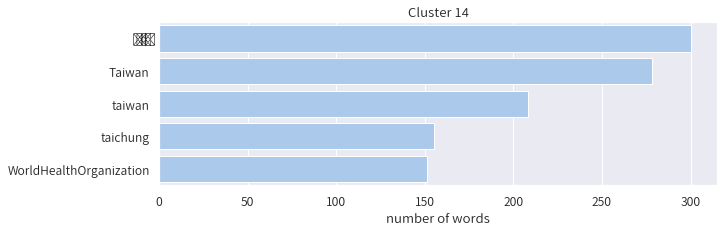

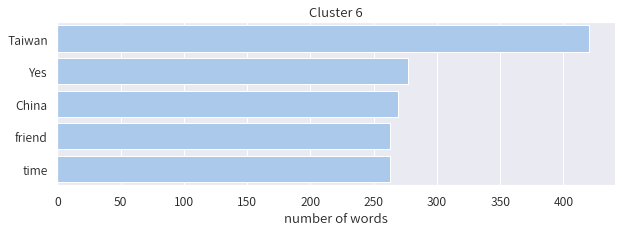

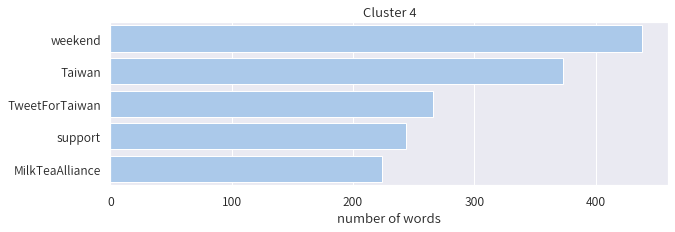

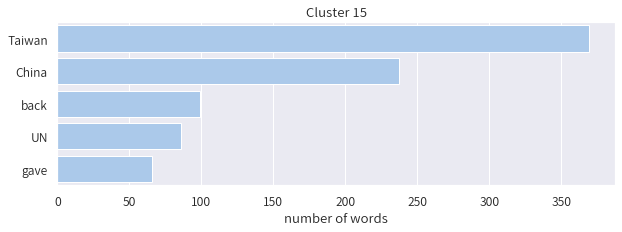

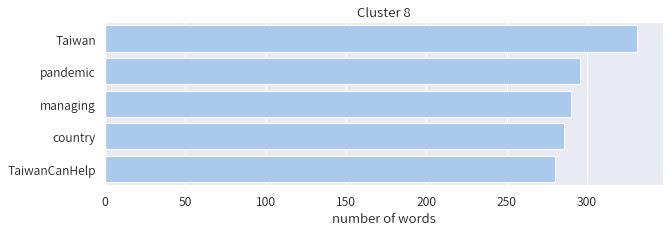

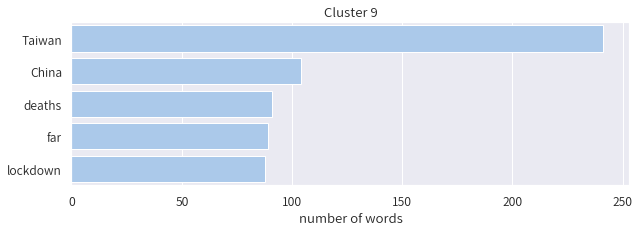

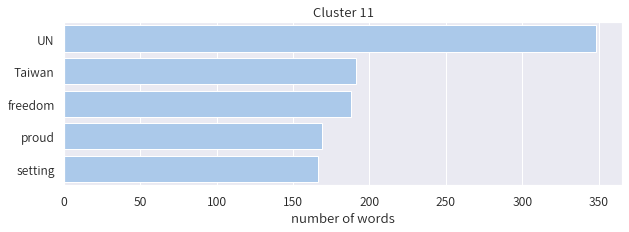

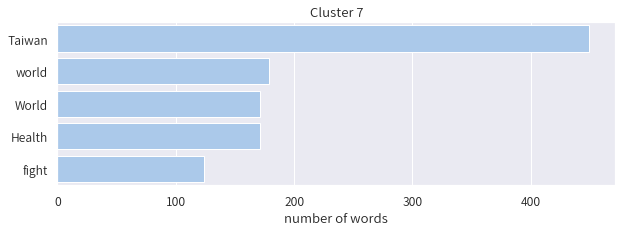

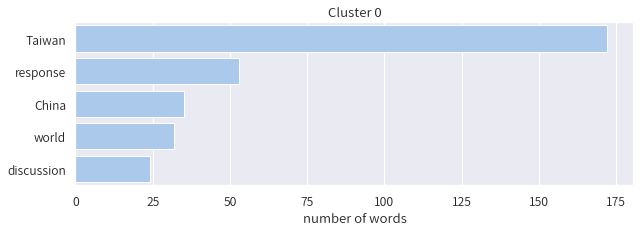

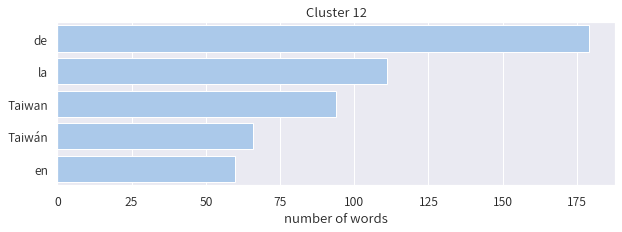

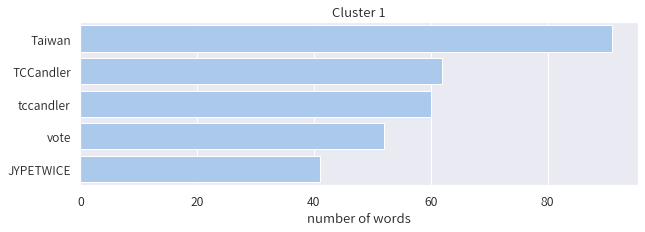

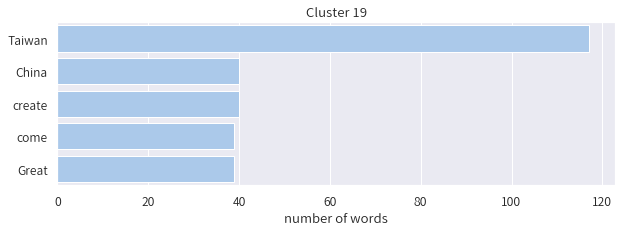

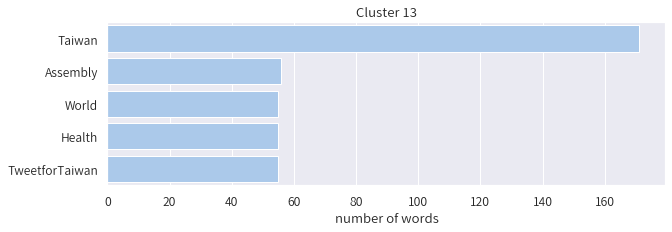

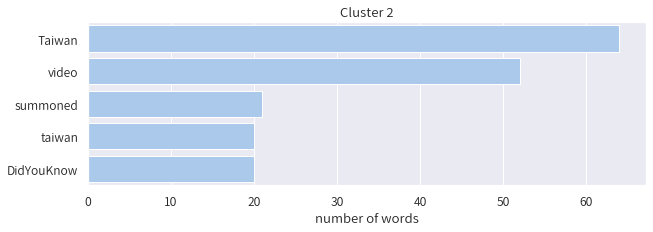

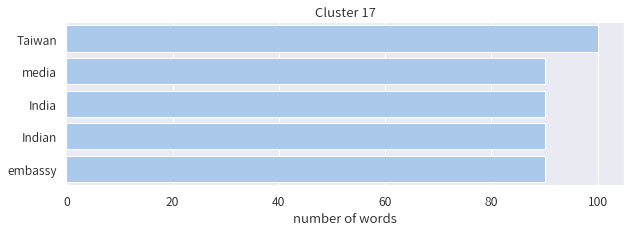

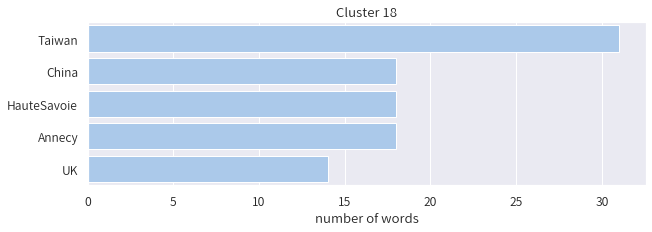

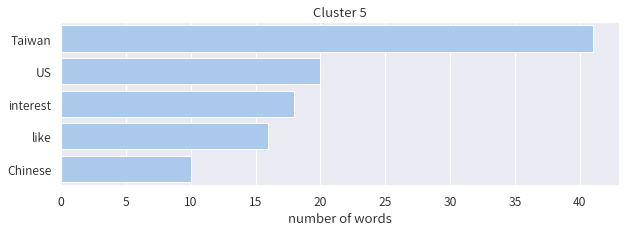

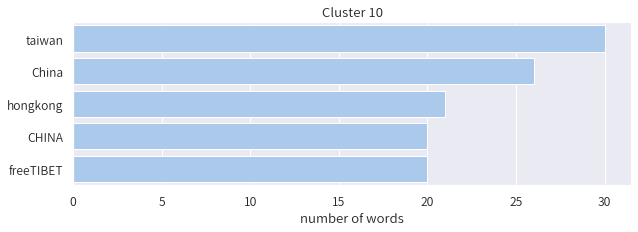

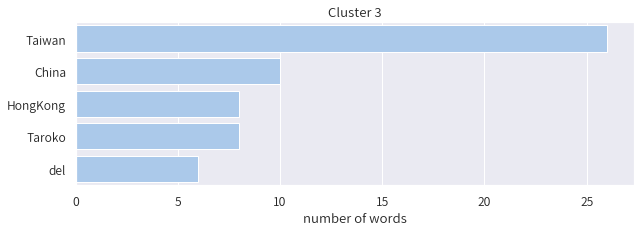

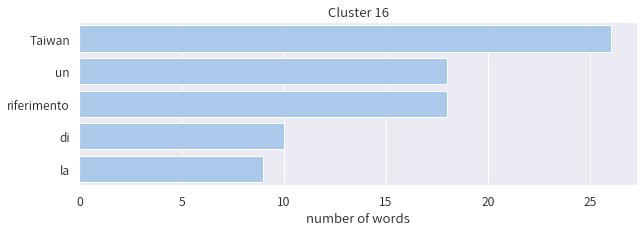

In [16]:
import seaborn as sns
import numpy as np   
import matplotlib.pyplot as plt

tweet_count = np.array(mgp.cluster_doc_count)
print('Number of tweets per topic :', tweet_count)
print('*'*20)

# Topics sorted by the number of document they are allocated to
top_index = tweet_count.argsort()[-20:][::-1]
print('Most important clusters (by number of tweets inside):', top_index)
print('*'*20)


# Show the top 5 words in term frequency for each cluster 
def viz(sort_dicts,cluster):
    sns.set(style="darkgrid", font_scale=1.1)
    plt.rcParams['font.sans-serif'] = ['Gen Jyuu Gothic']

    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize = (10, 3))

    # Load the example car crash dataset
    data = sort_dicts
    labels, ys = zip(*data)
    # Plot the total crashes
    sns.set_color_codes("pastel")
    ax.set_title('Cluster %s'%(cluster))
   
    sns.barplot(x="num", y="labels", data=pd.DataFrame({"num":list(ys),"labels":list(labels)}),
                 color="b")#label="Total",https://seaborn.pydata.org/examples/horizontal_barplot.html

    ax.set( ylabel="",xlabel="number of words")
#     sns.despine(left=True, bottom=True) 

def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print('Cluster %s : %s'%(cluster,sort_dicts))
        
        viz(sort_dicts,cluster)
        print(' — — — — — — — — — ')
        
# np.array(mgp.cluster_doc_count)
top_words(mgp.cluster_word_distribution, top_index, 5)

## Topic modeling : BTM
[code](https://github.com/markoarnauto/biterm)

In [16]:
import pandas as pd
# pattern = "&amp;|http[s]:[/A-Za-z\.0-9]*|nan|#|@"

df = pd.read_csv("ref/twitter/taiwan_tweets_text.csv")
# df = df.replace(pattern,'',regex=True)
df.info()
tweets = df.text.to_list()[:3500]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48963 entries, 0 to 48962
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  48963 non-null  int64 
 1   text        48963 non-null  object
dtypes: int64(1), object(1)
memory usage: 765.2+ KB


In [17]:
import numpy as np
import pyLDAvis
from biterm.cbtm import oBTM 
from sklearn.feature_extraction.text import CountVectorizer
from biterm.utility import vec_to_biterms, topic_summuary # helper functions

if __name__ == "__main__":

#     texts = open('./data/reuters.titles').read().splitlines()
    texts = tweets
    # vectorize texts
    vec = CountVectorizer(stop_words='english')
    X = vec.fit_transform(texts).toarray()

    # get vocabulary
    vocab = np.array(vec.get_feature_names())

    # get biterms
    biterms = vec_to_biterms(X)

    # create btm
#     btm = oBTM(num_topics=20, V=vocab)
    btm = oBTM(num_topics=20, V=vocab)

    print("\n\n Train Online BTM ..")
    for i in range(0, len(biterms), 100): # prozess chunk of 200 texts
        biterms_chunk = biterms[i:i + 100]
        btm.fit(biterms_chunk, iterations=50)
    topics = btm.transform(biterms)

    print("\n\n Visualize Topics ..")
    vis = pyLDAvis.prepare(btm.phi_wz.T, topics, np.count_nonzero(X, axis=1), vocab, np.sum(X, axis=0))
    pyLDAvis.save_html(vis, './btm/vis/online_btm_0520.html')

    print("\n\n Topic coherence ..")
    topic_summuary(btm.phi_wz.T, X, vocab, 10)

#     print("\n\n Texts & Topics ..")
#     for i in range(len(texts)):
#         print("{} (topic: {})".format(texts[i], topics[i].argmax()))

  0%|          | 0/50 [00:00<?, ?it/s]



 Train Online BTM ..


100%|██████████| 50/50 [09:45<00:00, 11.71s/it]




 Visualize Topics ..


 Topic coherence ..
Topic 0 | Coherence=-48.87 | Top words= taiwan https หว กอย taichung ไต เม เท บไปเท ความน
Topic 1 | Coherence=-90.96 | Top words= taiwan https support china health world organization countries little key
Topic 2 | Coherence=-126.49 | Top words= taiwan https health said world success dr social says voice
Topic 3 | Coherence=-97.41 | Top words= taiwan https amp taiwancanhelp like minded coronavirus partners thanks democracy
Topic 4 | Coherence=-76.21 | Top words= taiwan https il dell cinesi della che cina hongkong social
Topic 5 | Coherence=-80.86 | Top words= taiwan tweetfortaiwan health world assembly covid19 global beijing observer changed
Topic 6 | Coherence=-111.59 | Top words= taiwan https al del da mi gov asia italia distraggo
Topic 7 | Coherence=-145.01 | Top words= taiwan https china amp like chinese million policy world piece
Topic 8 | Coherence=-89.03 | Top words= taiwan https china chinese india indian piece minister principle tryi

### Result
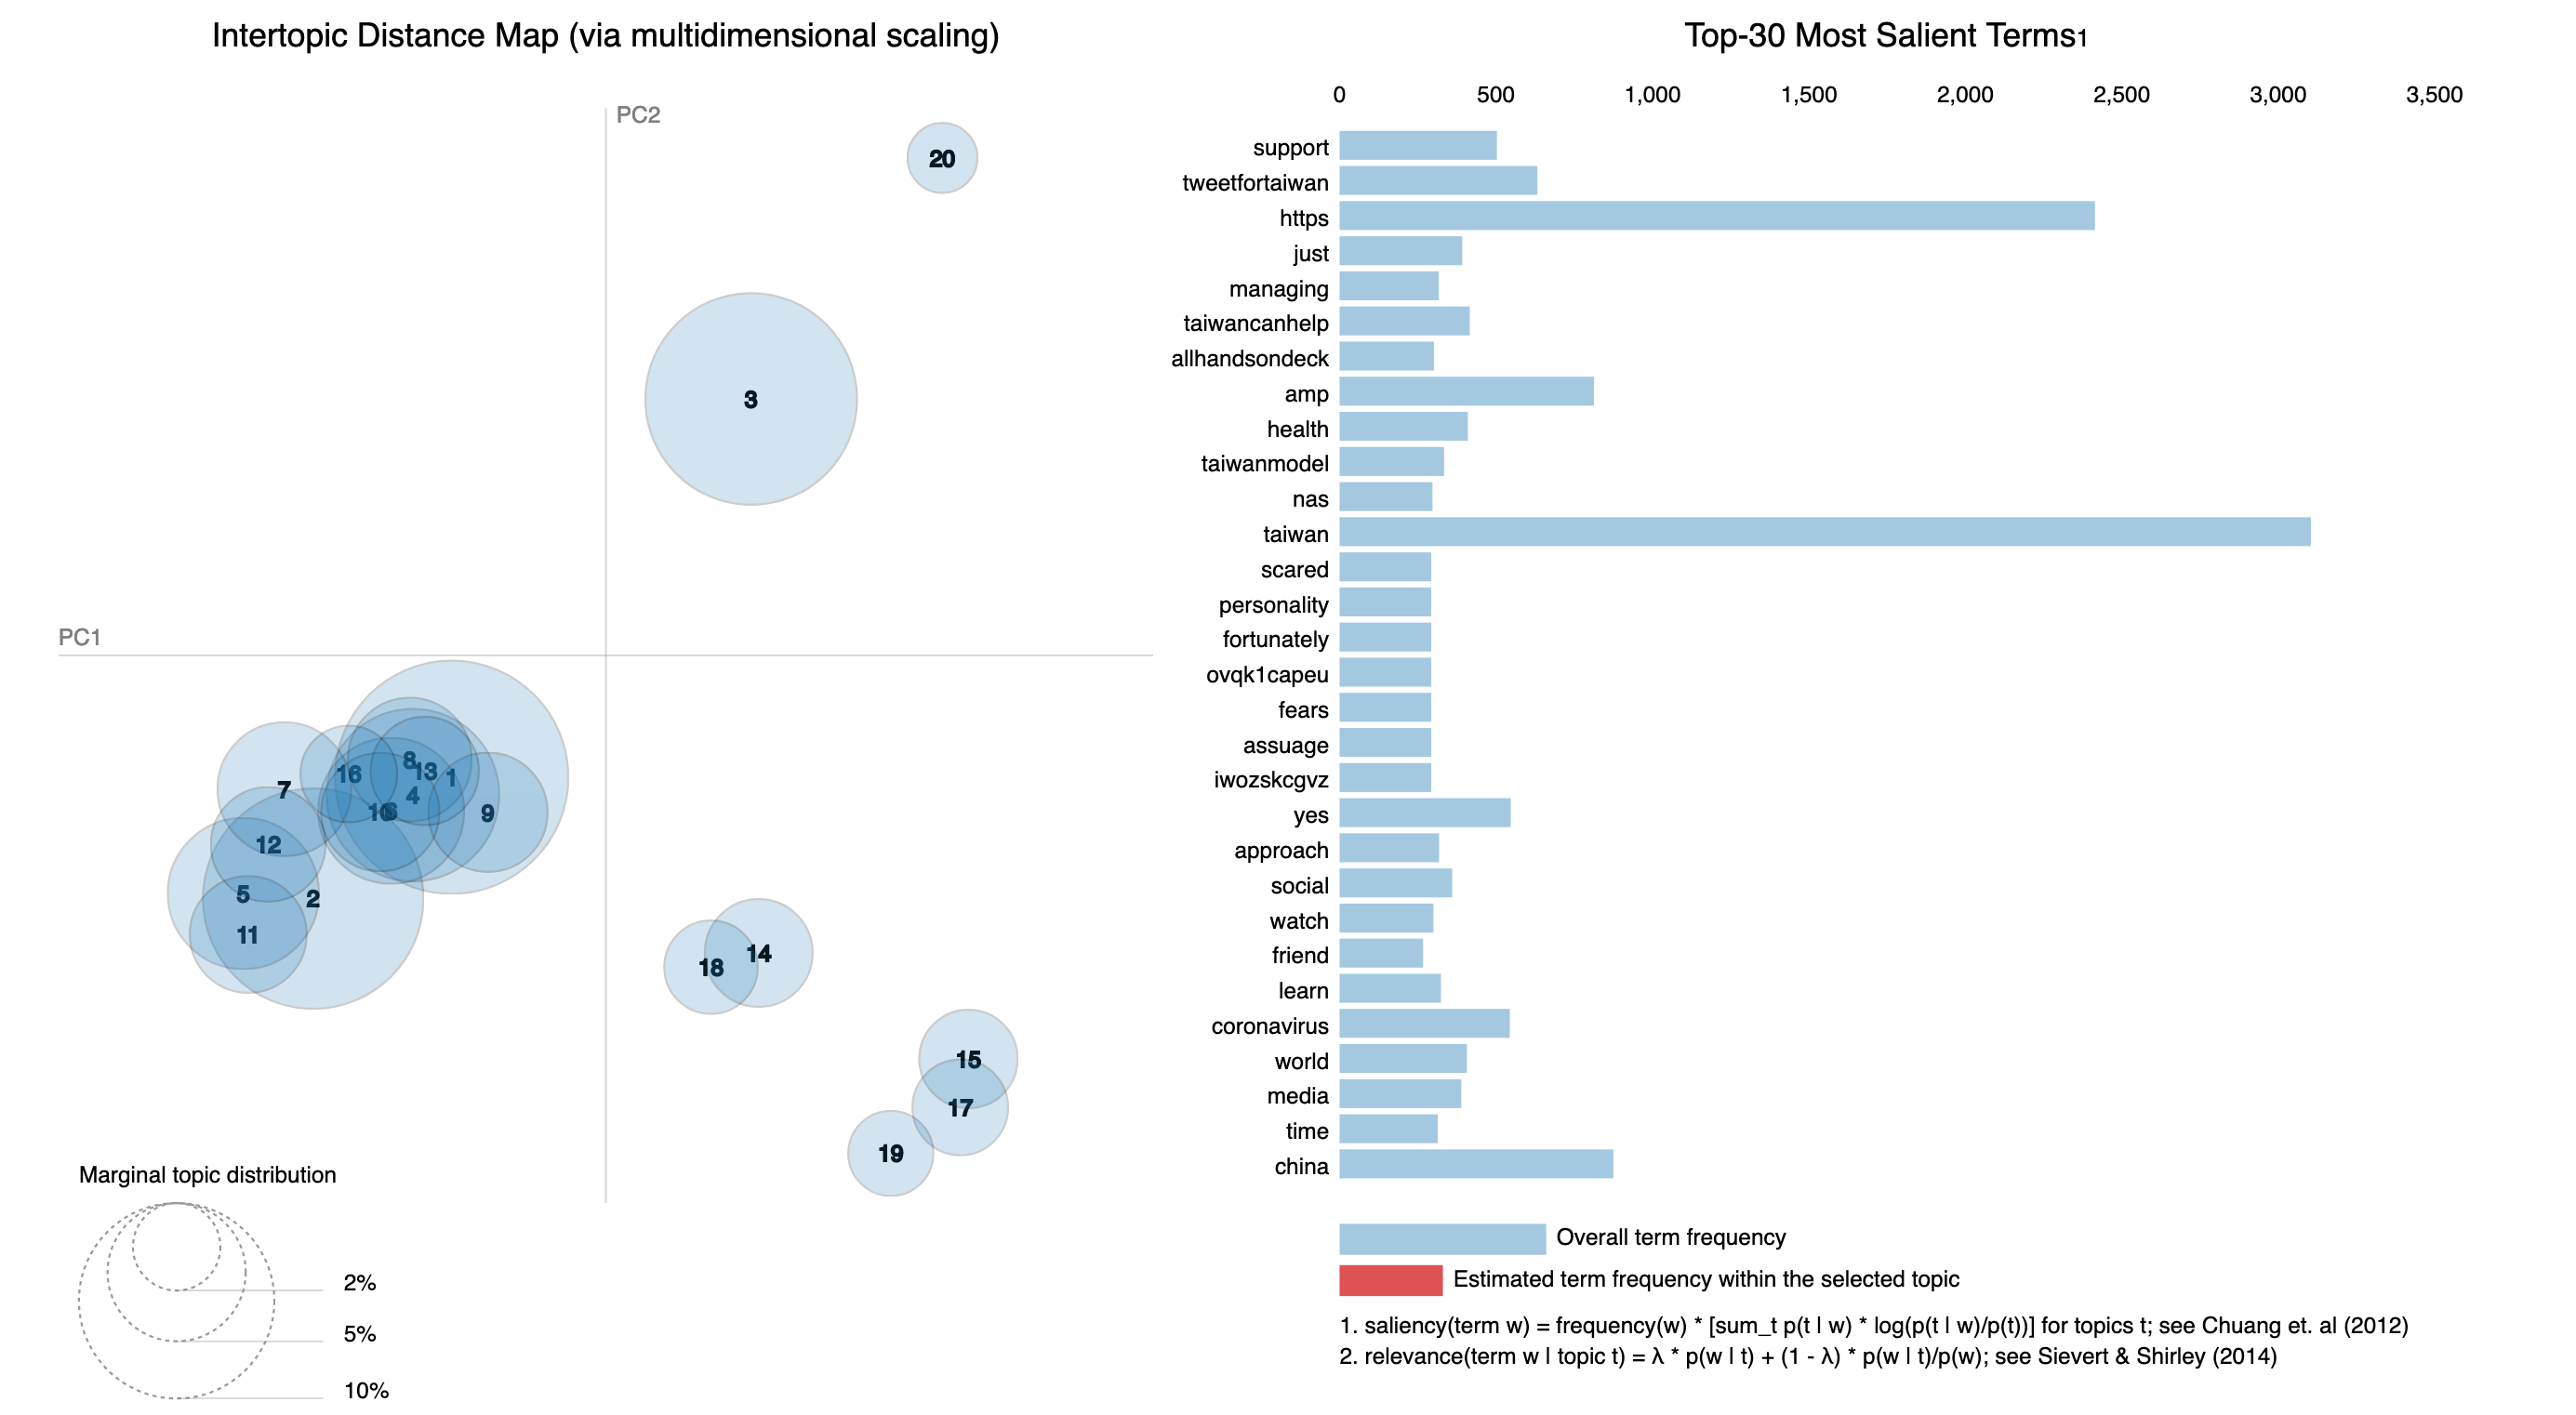